### 1. 데이터셋 내려받기

In [86]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    with_info=True,
    as_supervised=True,
)

### 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
- 이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches 준비

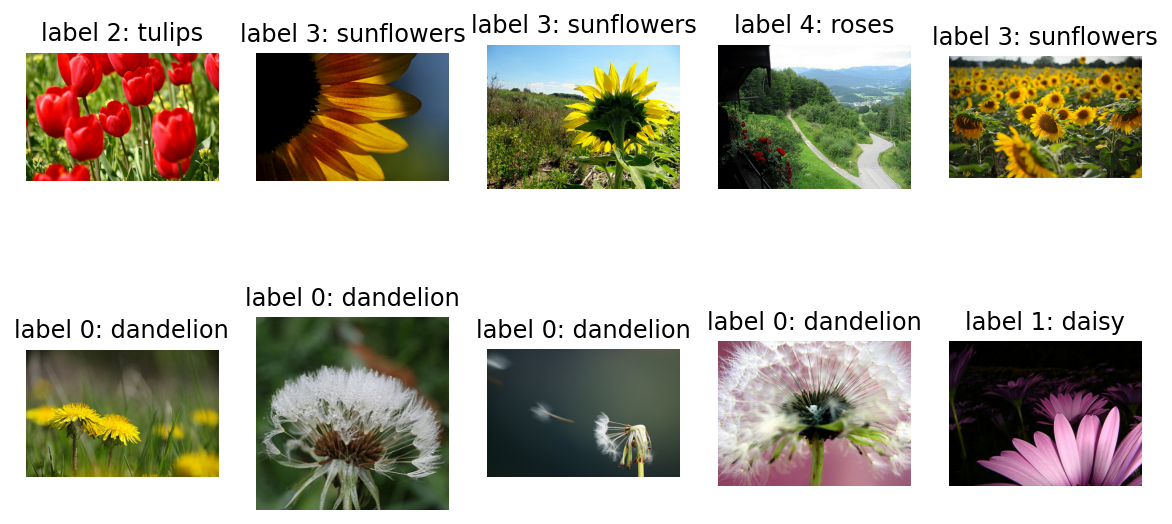

In [3]:
# 데이터 확인
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [4]:
# 이미지 크기 포맷
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [26]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

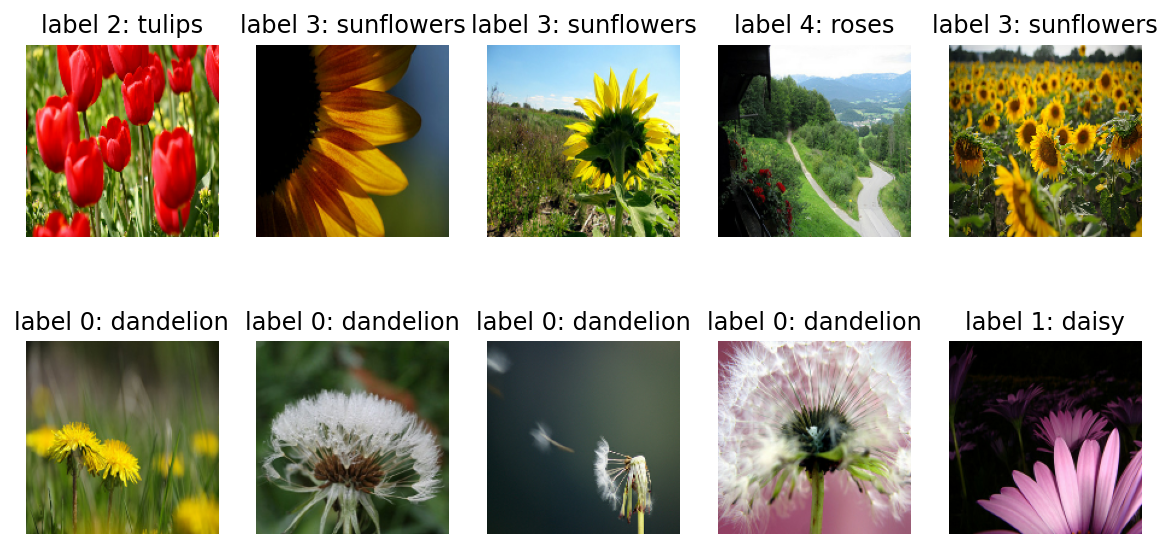

In [27]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train_batches.take(10)): # raw_train을 train으로 변경
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2  # matplotlib으로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야 하므로, -1~1 사이의 픽셀값을 1을 더한 후 2로 나눠서 0~1 사이의 값으로 변환
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')
    
    
# 결과: 이미지 크기 균일(160, 160, 3)

### 3. 모델 설계하기
- 데이터가 3,670개로 적기 때문에 base_model 이용

#### 3-1. 모델 구조 설계

In [28]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [29]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax') # 클래스 5개
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)            

### 4. 데이터 학습시키기
#### 4-1. 초기 모델

In [30]:
base_learning_rate = 0.0001   # 학습률(learning_rate) 파라미터 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), # 모델 컴파일
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [31]:
# 학습시킬 데이터 준비
BATCH_SIZE = 32  # 한 스텝에 학습시킬 데이터 개수
SHUFFLE_BUFFER_SIZE = 1000  # 학습 데이터 적절히 섞어주는 지표

In [33]:
# BATCH_SIZE에 따라 32개의 데이터를 랜덤 지정
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) # 모델이 끊임없이 학습할 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [34]:
# 하나의 batch 속 데이터 확인
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [17]:
# 모델의 예측 결과 확인
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[0.19774514, 0.23552203, 0.2194623 , 0.16989233, 0.17737819],
       [0.20012623, 0.19882075, 0.20320067, 0.20838064, 0.18947169],
       [0.18570018, 0.21569254, 0.20102194, 0.19531205, 0.20227335],
       [0.18928999, 0.23335113, 0.17919618, 0.2157543 , 0.18240839],
       [0.1931079 , 0.23018573, 0.19177437, 0.18802652, 0.19690546],
       [0.21030363, 0.20807825, 0.20946893, 0.18720497, 0.18494418],
       [0.20225269, 0.21661596, 0.18715091, 0.20936634, 0.18461408],
       [0.20275334, 0.19336161, 0.19764207, 0.21646166, 0.18978137],
       [0.19760972, 0.22944276, 0.19795814, 0.18992683, 0.1850625 ],
       [0.19321021, 0.20377842, 0.2070676 , 0.20264591, 0.19329785],
       [0.19049881, 0.20667623, 0.1925031 , 0.21138297, 0.1989389 ],
       [0.19552372, 0.2112466 , 0.2128824 , 0.18753052, 0.1928168 ],
       [0.21802638, 0.23729707, 0.19692391, 0.17427076, 0.17348191],
       [0.19449596, 0.21872218, 0.18164873, 0.21737231, 0.18776079],
       [0.19956666, 0.1962959 , 0.

#### 4-2. 사전학습모델 VGG16

In [45]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                         include_top=False, 
                                         weights='imagenet')
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
base_model.trainable = False

model = tf.keras.Sequential([
  base_model, 
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [98]:
base_learning_rate = 0.0003   # 학습률(learning_rate) 파라미터 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), # 모델 컴파일
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [99]:
EPOCHS = 7

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/7
92/92 [==============================] - 7s 77ms/step - loss: 0.3687 - accuracy: 0.8791 - val_loss: 0.4508 - val_accuracy: 0.8311
Epoch 2/7
92/92 [==============================] - 7s 75ms/step - loss: 0.3511 - accuracy: 0.8801 - val_loss: 0.4466 - val_accuracy: 0.8447
Epoch 3/7
92/92 [==============================] - 7s 75ms/step - loss: 0.3391 - accuracy: 0.8879 - val_loss: 0.4606 - val_accuracy: 0.8311
Epoch 4/7
92/92 [==============================] - 7s 75ms/step - loss: 0.3275 - accuracy: 0.8910 - val_loss: 0.4491 - val_accuracy: 0.8311
Epoch 5/7
92/92 [==============================] - 7s 77ms/step - loss: 0.3149 - accuracy: 0.8941 - val_loss: 0.4588 - val_accuracy: 0.8365
Epoch 6/7
92/92 [==============================] - 7s 75ms/step - loss: 0.3068 - accuracy: 0.8927 - val_loss: 0.4600 - val_accuracy: 0.8283
Epoch 7/7
92/92 [==============================] - 7s 77ms/step - loss: 0.2992 - accuracy: 0.9016 - val_loss: 0.4323 - val_accuracy: 0.8447


### 5. 모델 성능 평가

#### 5-1. 학습 과정 그래프

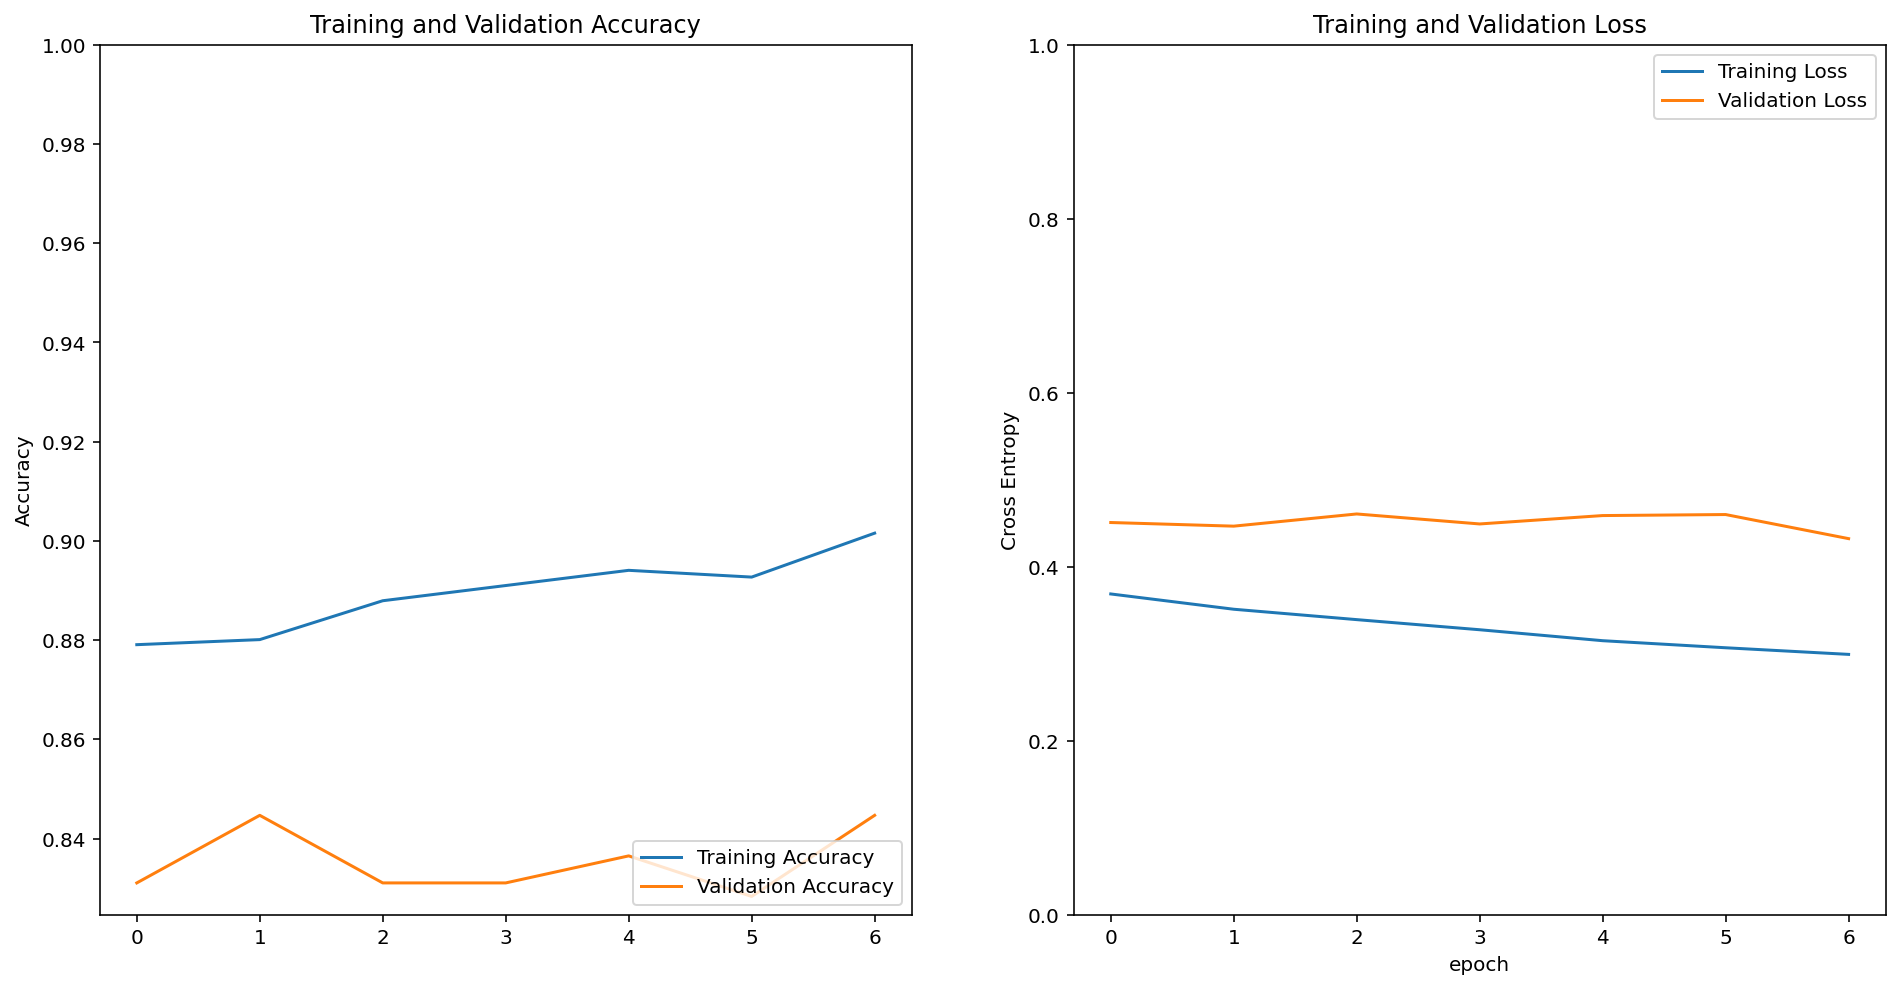

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### 5-2. 예측 결과

In [101]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.79707434e-03, 1.99326277e-02, 9.20328975e-01, 4.32781363e-03,
        5.36135212e-02],
       [9.99950528e-01, 4.76127680e-05, 7.45630331e-08, 2.08053777e-07,
        1.71950421e-06],
       [6.55859947e-01, 2.02729315e-01, 1.90058369e-02, 1.13707565e-01,
        8.69730022e-03],
       [1.38200063e-04, 9.93242022e-04, 7.73453236e-01, 1.84460965e-04,
        2.25230843e-01],
       [6.67919397e-01, 3.14547449e-01, 6.07239921e-03, 5.38492948e-03,
        6.07584603e-03],
       [9.66172278e-01, 2.54550278e-02, 1.05825078e-03, 7.16092018e-03,
        1.53621892e-04],
       [8.45109462e-04, 3.37745529e-04, 9.90200341e-01, 5.35691949e-03,
        3.25981411e-03],
       [2.72292793e-01, 7.20296085e-01, 8.13690422e-05, 7.09416391e-03,
        2.35535816e-04],
       [9.37297125e-04, 7.02474281e-05, 1.12908771e-02, 9.76118147e-01,
        1.15834009e-02],
       [9.99905825e-01, 9.31289542e-05, 8.61999254e-08, 8.12186784e-07,
        1.28397573e-07],
       [9.77559030e-01, 2.0938

#### 5-3. prediction값 라벨로 변환

In [102]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 2, 4, 4, 3, 0, 4])

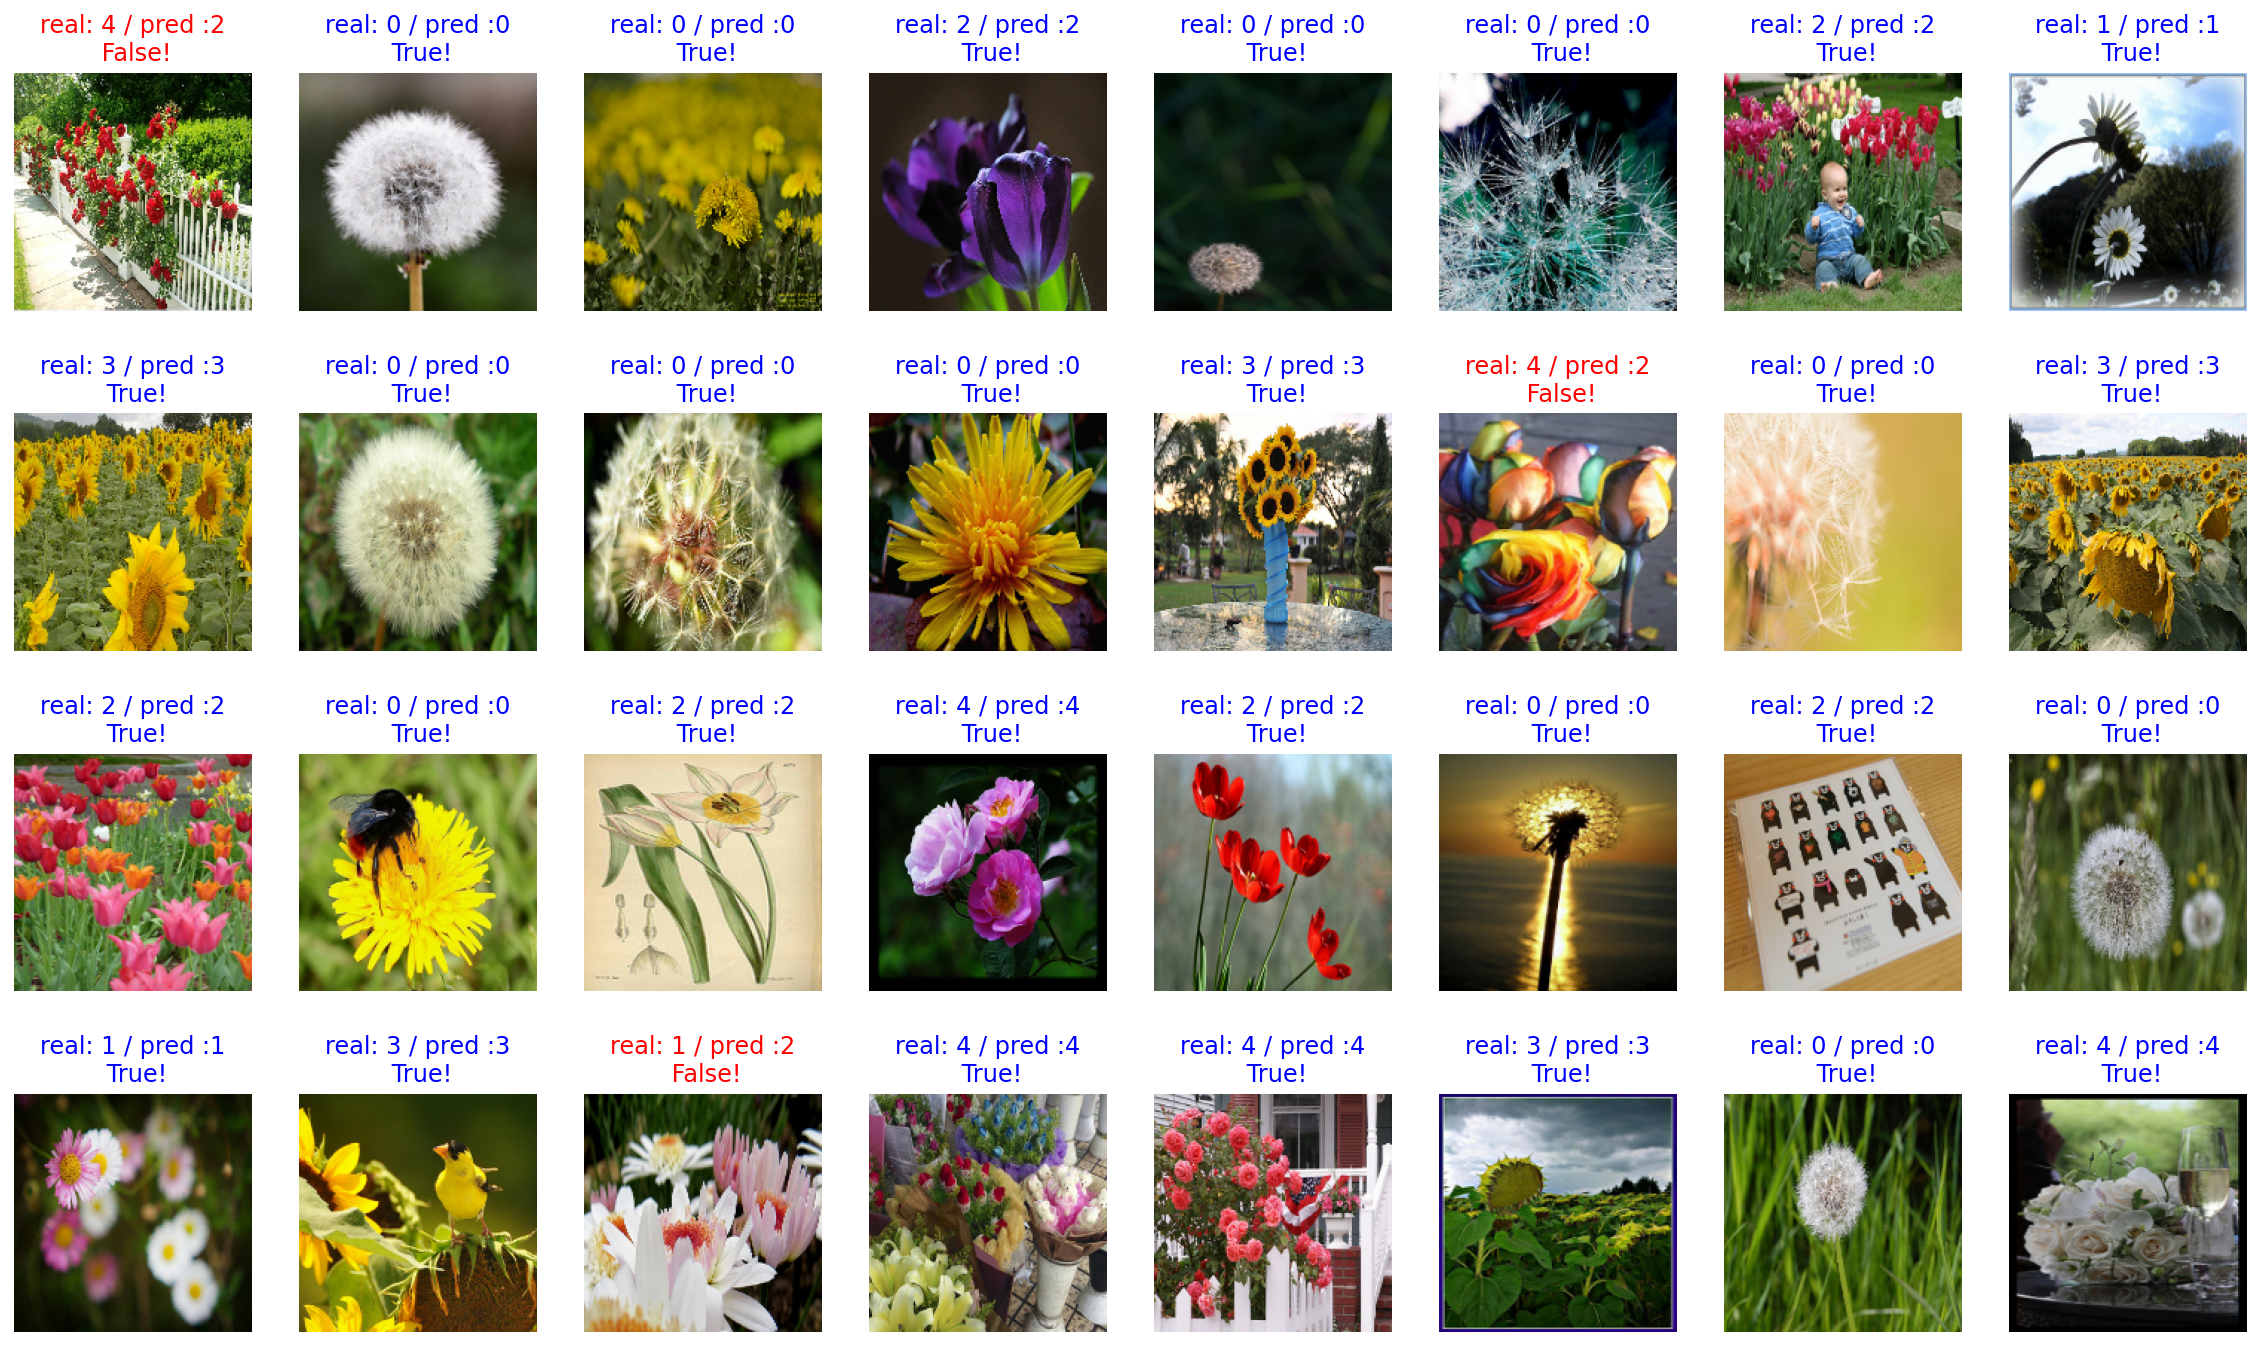

In [103]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

#### 5-4. 정확도 확인

In [104]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(f"accuracy: {count / 32 * 100}")

accuracy: 90.625


### 6. 모델 활용

In [105]:
import os

checkpoint_dir = os.getenv("HOME") + "/workplace/aiffel/Exploration/04. 이미지 분류/flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [106]:
img_dir_path = os.getenv("HOME") + "/workplace/aiffel/Exploration/04. 이미지 분류/flowers/images"
os.path.exists(img_dir_path)

True

In [135]:
# 분류 함수
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    rose_percentage = round(prediction[4] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulip_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    dandelion_percentage = round(prediction[0] * 100)
    print(f"This image seems {rose_percentage}% rose, {daisy_percentage}% daisy, {tulip_percentage}% tulip, {sunflower_percentage}% sunflower, {dandelion_percentage}% dandelion.")

#### Test1. 정확한 튤립 사진: 튤립 100% 달성

In [136]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 160
tulip_image_path = os.path.join(img_dir_path, 'my_tulip.jpeg')

tulip_image = load_img(tulip_image_path, target_size=(IMG_SIZE, IMG_SIZE))

In [137]:
# 이미지를 배열 자료형으로 변환
tulip_image = img_to_array(tulip_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
tulip_image.shape

(1, 160, 160, 3)

In [138]:
# 모델에 넣어 예측: 튤립은 라벨 2 [[0., 0., 1., 0., 0.]]
prediction = model.predict(tulip_image)
prediction

array([[0., 0., 1., 0., 0.]], dtype=float32)

This image seems 0.0% rose, 0.0% daisy, 100.0% tulip, 0.0% sunflower, 0.0% dandelion.


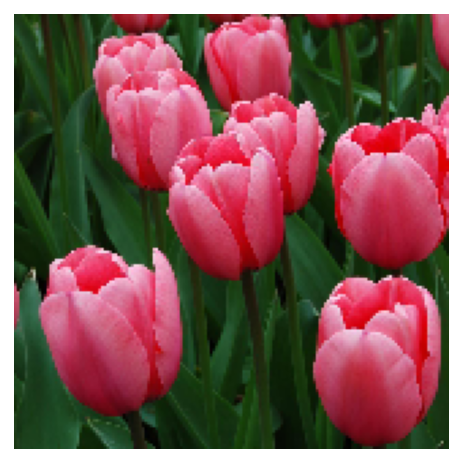

In [139]:
filename = 'my_tulip.jpeg'

show_and_predict_image(img_dir_path, filename)

#### Test2. 어둡고 주변 색과 비슷한 해바라기 사진: 정확도가 대폭 감소하여 데이지(라벨 1)로 분류

In [140]:
sunflower_image_path = os.path.join(img_dir_path, 'my_sunflower.jpeg')

sunflower_image = load_img(sunflower_image_path, target_size=(IMG_SIZE, IMG_SIZE))

In [141]:
# 이미지를 배열 자료형으로 변환: 해바라기 라벨 3 
sunflower_image = img_to_array(sunflower_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
sunflower_image.shape

(1, 160, 160, 3)

In [142]:
prediction = model.predict(sunflower_image) # [[0., 0., 0., 1., 0.]]
prediction

array([[3.9490356e-38, 9.7963518e-01, 3.3991388e-33, 2.0364823e-02,
        0.0000000e+00]], dtype=float32)

This image seems 0.0% rose, 98.0% daisy, 0.0% tulip, 2.0% sunflower, 0.0% dandelion.


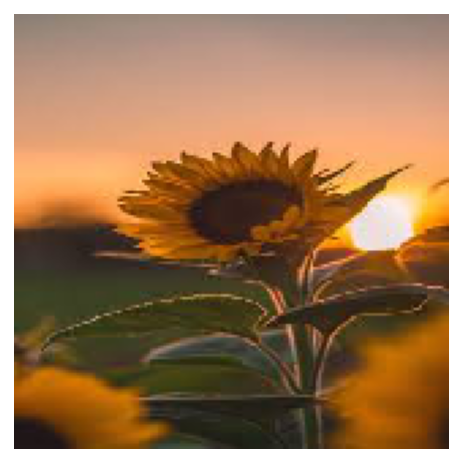

In [143]:
filename = 'my_sunflower.jpeg'

show_and_predict_image(img_dir_path, filename)

#### Test3. 인간 장미 사진: 장미 99%로 평가, 해당 연예인은 장미 상인 걸로 판단.

In [144]:
rose_image_path = os.path.join(img_dir_path, 'human_rose.jpeg')
rose_image = load_img(rose_image_path, target_size=(IMG_SIZE, IMG_SIZE))
rose_image = img_to_array(rose_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
rose_image.shape

(1, 160, 160, 3)

In [145]:
prediction = model.predict(rose_image) # [[0., 0., 0., 0., 1.]]
prediction

array([[0.        , 0.        , 0.        , 0.01033221, 0.9896678 ]],
      dtype=float32)

This image seems 99.0% rose, 0.0% daisy, 0.0% tulip, 1.0% sunflower, 0.0% dandelion.


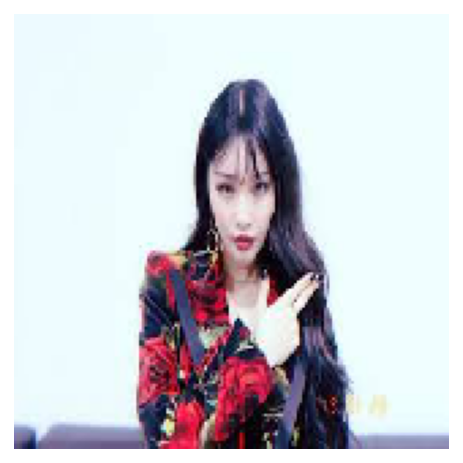

In [146]:
filename = 'human_rose.jpeg'
show_and_predict_image(img_dir_path, filename)

### 평가
